In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import njit
import h5py as h5
from scipy.spatial import KDTree

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [3]:
name = 'MW3_MHG0.25_GSE2'
lvl = 4
snap = 200
sn = arepo.Snapshot(basepath+'runs/'+name+'/lvl'+str(lvl)+'/output', snap, combineFiles=True)

In [4]:
COM_file = np.load(basepath+'anlys/COM/COM_'+name+'-lvl'+str(lvl)+'.npy', allow_pickle=True).item()
COM = COM_file['Tot_COM'][snap]
rng0 = [[-80, 80], [-80, 80]]

In [32]:
def get_pos_mass(sn, ptypes):
    pos = []
    mass = []
    for pt in ptypes:
        if sn.NumPart_Total[pt] > 0:
            part = getattr(sn, 'part'+str(pt))
            pos.append(part.pos.value)
            if sn.MassTable[pt] > 0.0:
                mass.append(np.full(sn.NumPart_Total[pt], sn.MassTable[pt]))
            else:
                mass.append(part.mass.value)

    pos = np.concatenate(pos)
    mass = np.concatenate(mass)
    return pos, mass

def get_gas_pos_mass(sn):
    pos = sn.part0.pos.value
    mass = sn.part0.mass.value
    
    vol = sn.part0.mass.value/sn.part0.rho.value
    h = ((3/(4*np.pi))*vol)**(1/3)

    return pos, mass, h

In [23]:
def compute_projections(sn, COM, rng=[[-15, 15], [-15, 15]]):
    # rng = [[-15, 15], [-15, 15]]
    nres = 256

    dx = (rng[0][1]-rng[0][0]) / nres
    dy = (rng[1][1]-rng[1][0]) / nres
    surf_area = dx * dy

    # First do stars
    pos, mass = get_pos_mass(sn, [2, 3, 4])
    pos = pos - COM

    Hxy_s, _, _ = np.histogram2d(pos[:,0], pos[:,1], bins=(nres, nres),
        range=rng, weights=mass/surf_area)

    Hxz_s, _, _ = np.histogram2d(pos[:,0], pos[:,2], bins=(nres, nres),
        range=rng, weights=mass/surf_area)

    # Now do gas
    if sn.NumPart_Total[0] > 0:
        pos, mass, h = get_gas_pos_mass(sn)
        pos = pos - COM

        Hxy_g = get_gas_proj(pos[:,0], pos[:,1], (nres, nres), rng)
        
        # Hxy_g, _, _ = np.histogram2d(pos[:,0], pos[:,1], bins=(nres, nres),
            # range=rng, weights=mass/surf_area)

        # Hxz_g, _, _ = np.histogram2d(pos[:,0], pos[:,2], bins=(nres, nres),
            # range=rng, weights=mass/surf_area)
    else:
        Hxy_g = Hxz_g = np.zeros((nres, nres))

    return Hxy_s, Hxz_s, Hxy_g, Hxz_g


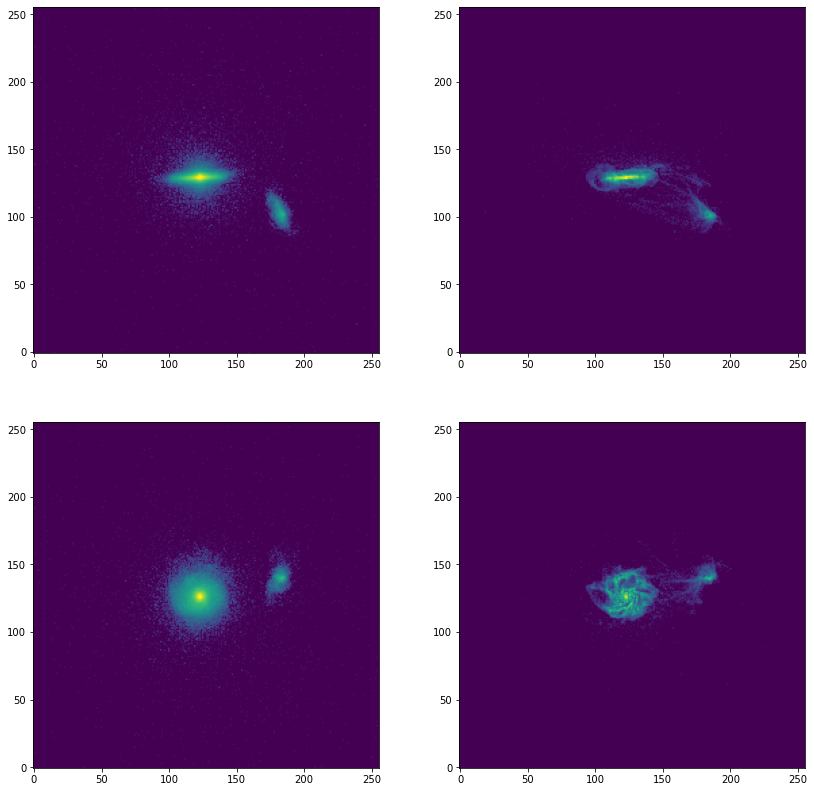

In [30]:
vmin_s = 1E-5
vmax_s = 1E-1
vmin_g = 1E-4
vmax_g = 1E-1

Hxy_s, Hxz_s, Hxy_g, Hxz_g = compute_projections(sn, COM, rng0)

Hxy_s[Hxy_s < vmin_s] = vmin_s
Hxz_s[Hxz_s < vmin_s] = vmin_s
Hxy_g[Hxy_g < vmin_g] = vmin_g
Hxz_g[Hxz_g < vmin_g] = vmin_g

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

im00 = ax[0][0].imshow(Hxz_s.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin_s, vmax=vmax_s))
im10 = ax[1][0].imshow(Hxy_s.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin_s, vmax=vmax_s))

im00 = ax[0][1].imshow(Hxz_g.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin_g, vmax=vmax_g))
im10 = ax[1][1].imshow(Hxy_g.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin_g, vmax=vmax_g))

In [60]:
@njit
def create_3D_grid(nres, width):
    xlist = width * ((np.arange(nres) + 0.5) / nres - 0.5)
    
    grid = np.zeros((nres, nres, nres, 3))
    
    for i in range(nres):
        for j in range(nres):
            for k in range(nres):
                grid[i][j][k][0] = xlist[i]
                grid[i][j][k][1] = xlist[j]
                grid[i][j][k][2] = xlist[k]
    
    return grid
    

In [ ]:
def get_gas_proj(pos, nres, width, Ngb=32):
    tree = KDTree(pos)
    
    # construct 3D grid
    grid = create_3D_grid(nres, width)
    
    # query tree
    tree.query(grid
    

In [109]:
pos, mass, h = get_gas_pos_mass(sn)
pos = pos-COM
tree = KDTree(pos)

In [117]:
nres = 256
width = 80
xlist = width * ((np.arange(nres) + 0.5) / nres - 0.5)

In [118]:
grid = create_3D_grid(nres, width)
grid[nres-1][nres-1][128]

array([39.84375, 39.84375,  0.15625])

In [119]:
d, idx = tree.query(grid, 32)

In [120]:
@njit 
def kernel(d, h):
    if d/h > 1.:
        return 0.0
    elif 0.5 < d/h <= 1.:
        ans = 2 * (1 - d/h)**3
        ans *= 8/(np.pi*h**3)
        return ans
    else:
        ans = 1 - 6 * (d/h)**2 + 6 * (d/h)**3
        ans *= 8/(np.pi*h**3)
        return ans
    
@njit
def compute_rho_grid(nres, mass, h, d, idx):
    
    rho_grid = np.zeros((nres, nres, nres))
    
    for i in range(nres):
        for j in range(nres):
            for k in range(nres):
                for l in range(32):
                    idx_ = idx[i][j][k][l]
                    rho_grid[i][j][k] += mass[idx_] * kernel(d[i][j][k][l], h[idx_])
    
    return rho_grid

In [121]:

mass = sn.part0.mass.value

rho_grid = compute_rho_grid(nres, mass, h, d, idx)

In [122]:
surf_dens = np.trapz(rho_grid, xlist, axis=2)

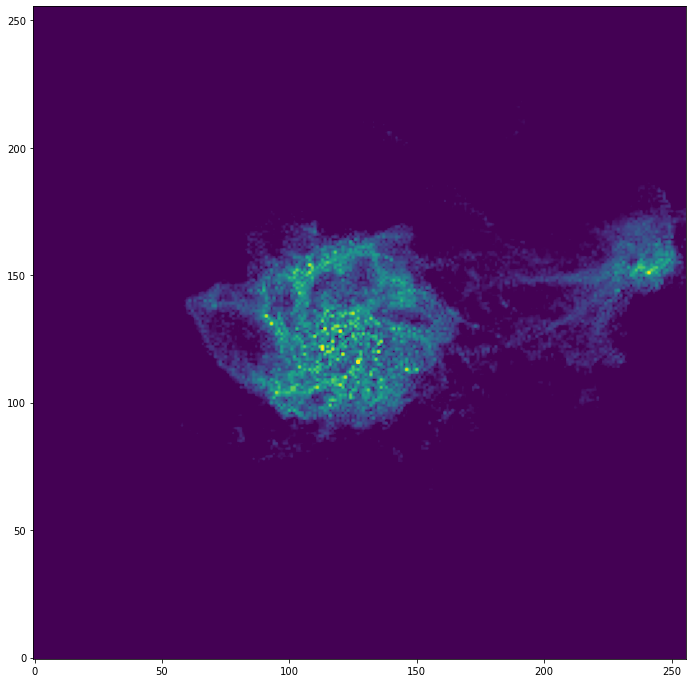

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
im = ax.imshow(surf_dens.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin_g, vmax=vmax_g))

## vortrace

In [5]:
from vortrace import vortrace as vt

In [34]:
name = 'MW3_MHG0.25_GSE2'
lvl = 4
snap = 0
sn = arepo.Snapshot(basepath+'runs/'+name+'/lvl'+str(lvl)+'/output', snap, combineFiles=True)

In [35]:
COM_file = np.load(basepath+'anlys/COM/COM_'+name+'-lvl'+str(lvl)+'.npy', allow_pickle=True).item()
COM = COM_file['Tot_COM'][snap]

In [36]:
pos = sn.part0.pos.value
rho = sn.part0.rho.value
BoxSize = sn.BoxSize

In [18]:
pc = vt.ProjectionCloud(pos, rho, boundbox=[0., BoxSize, 0., BoxSize, 0., BoxSize])

Applying bounding box...
npart: 683805
Snapshot loaded.
Building tree...
Tree build took 119 milliseconds.


In [32]:
L = 80.
extent = [[COM[0]-L/2., COM[0]+L/2.], [COM[2]-L/2., COM[2]+L/2.]]
bounds = [0., BoxSize]
npix = 256
# center = [BoxSize/2., BoxSize/2., BoxSize/2.]

dat_xy = pc.projection(extent, npix, bounds, COM, proj='xz')

Making projection...
Projection generation took 16547 milliseconds.


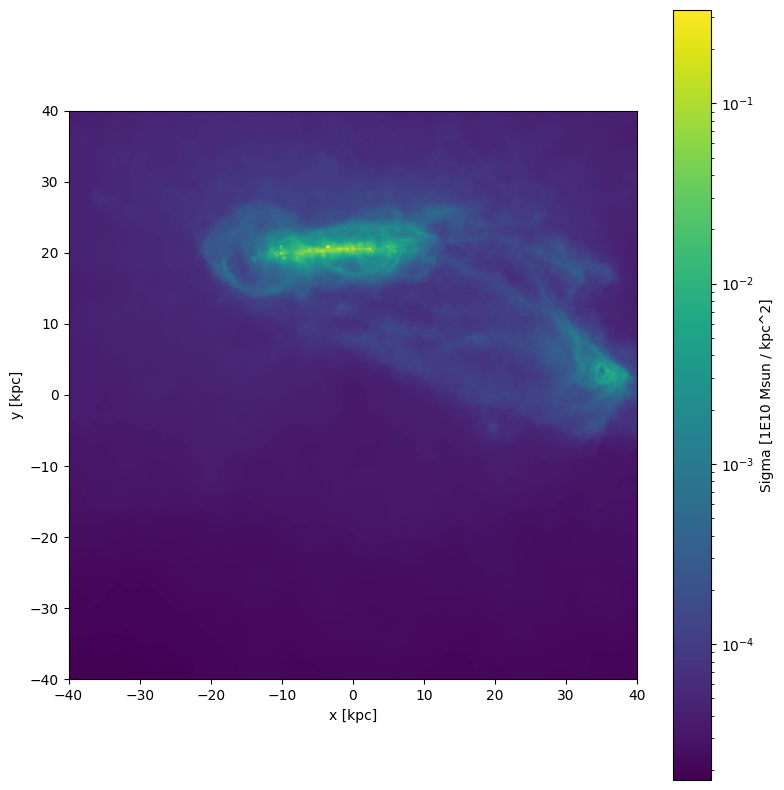

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

im = ax.imshow(dat_xy.T, extent=[-L/2., L/2., -L/2., L/2.], origin = 'lower', norm=mpl.colors.LogNorm())

ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')

fig.colorbar(im, ax=ax, label='Sigma [1E10 Msun / kpc^2]')
fig.tight_layout()

plt.show()